In [49]:
import os
import math
import re
from pysqlcipher3 import dbapi2 as sqlite
import pandas as pd
import numpy as np
import csv
import time
import datetime as dt
import jieba
import matplotlib 
from wordcloud import WordCloud
import jieba.analyse
import matplotlib.pyplot as plt 
from itertools import chain
from collections import Counter
from statsmodels.graphics.mosaicplot import mosaic
%matplotlib inline

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)

font = {'size'   : 14}
matplotlib.rc('font', **font)

df = pd.read_csv('zsy.csv')[7:]
# df = df.astype(str)

In [3]:
#Clean Data
#1: Change into a same timezone 
#2: Add fake data between 20th Sept to 29th Sept

#Winter time starts from 3rd Nov, to 8th Mar
#In local time, it's (2019, 11, 3, 13,00,00) to (2020,03,08,13,00,00)
#During this region, time difference is 14 hours, besides that, it's 13 hours

In [4]:
#1:
def select_user(df, num = 0):
    return df[df['Des'] == num]

ql = select_user(df, 0)
zsy = select_user(df, 1)

ql_flight_start_time = dt.datetime(2019, 8, 20, 17, 18, 0)
start_timestamp = dt.datetime.timestamp(ql_flight_start_time)
ql_flight_end_time = dt.datetime(2020,3,23,4,0,0)
end_timestamp = dt.datetime.timestamp(ql_flight_end_time)
winter_time_start = dt.datetime.timestamp(dt.datetime(2019,11,3,13,0,0))
winter_time_end = dt.datetime.timestamp(dt.datetime(2020,3,8,13,0,0))

def add_hour(x):
    '''
    Add 13 hours in summmer time, and 14 hours in winter time, units are in seconds
    '''
    x = int(x)
    if x > start_timestamp and x < end_timestamp:
        if x > winter_time_start and x < winter_time_end:
            x + 3600*14
        else:
            x + 3600*13
    return x

def cleaning_df(df):
    df_copy = df.copy()
    df_copy.loc[:,'CreateTime'] = df_copy['CreateTime'].apply(add_hour)
    return df_copy
    
ql = cleaning_df(ql)

frames = [zsy,ql]
df = pd.concat(frames)
df

,CreateTime,Des,ImgStatus,MesLocalID,Message,MesSvrID,Status,TableVer,Type
19,1560338147,1,1,148,"<msg><emoji fromusername = ""wxid_7owta77s1jny1...",5496851137703119850,4,0,47
29,1560412998,1,2,158,"<?xml version=""1.0""?>\n<msg>\n\t<img aeskey=""7...",3165674055171868097,4,0,3
30,1560425176,1,1,159,我姐不让我买air 她说和Pro性能有差距？,3239447859263969767,4,0,1
33,1560425258,1,1,162,呢我还是买Pro,2707797544080707869,4,0,1
34,1560425261,1,1,163,吧,131610092295736299,4,0,1
...,...,...,...,...,...,...,...,...,...
52277,1609085706,0,1,52281,打错了…,8283586982143939248,2,1,1
52279,1609088296,0,1,52283,霍霍回家啦,5377193127016655665,2,1,1
52280,1609088300,0,1,52284,晚安宝宝,1990312589582544353,2,1,1
52281,1609088302,0,1,52285,爱你你,6264009042995348646,2,1,1


In [5]:
#2:
def day_yr19(x):
    d = dt.datetime.fromtimestamp(x)- dt.datetime(2019,1,1)
    return str(d.days + 1)
#     return str(dt.datetime.fromtimestamp(x).strftime('%j'))

def day_yr20(x):
    d = dt.datetime.fromtimestamp(x)- dt.datetime(2020,1,1)
    return str(d.days + 1)

#Number of messages throughout a given year with units week
def get_dict(df, day = day_yr19):
    df_copy = df.copy()
    df_copy.loc[:,'CreateTime'] = df_copy['CreateTime'].apply(day)
#     print(df_copy['CreateTime'])
    d = [str(i) for i in sorted(list(set(df_copy['CreateTime'])))]
    m = {}
    for i in d:
        m[int(i)] = len(df_copy[df_copy['CreateTime'] == str(i)])
#     m.sort(key = lambda x:x.keys())
    m = dict(sorted(m.items()))
    return m

def mend_data(m, df):
    std = np.std(pd.Series(m.values()))
    mean = np.mean(pd.Series(m.values()))
    std_mean = (std,mean)

    a = [m[i] for i in range(252,262)]
    b = [m[i] for i in range(273,283)]
    msg = int((sum(a)/len(a) + sum(b)/len(b)) / 2 )
    
    n = list(m.keys())
    for i in list(range(n[0],n[-1]+1)):
        if i not in m.keys():
            m[i] = msg + int(np.random.normal(*std_mean,1))
    return dict(sorted(m.items()))

In [6]:
dt.datetime.fromtimestamp(1583138497)

datetime.datetime(2020, 3, 2, 16, 41, 37)

In [7]:
[dt.datetime.fromtimestamp(int(i)) for i in list(zsy[zsy['CreateTime'] > 1568822400.0].CreateTime)]

[datetime.datetime(2019, 9, 19, 7, 14, 52),
 datetime.datetime(2019, 9, 19, 11, 51, 22),
 datetime.datetime(2019, 9, 19, 11, 52, 29),
 datetime.datetime(2019, 9, 19, 11, 53, 44),
 datetime.datetime(2019, 9, 30, 9, 10, 24),
 datetime.datetime(2019, 9, 30, 10, 0, 27),
 datetime.datetime(2019, 9, 30, 10, 0, 37),
 datetime.datetime(2019, 9, 30, 10, 0, 48),
 datetime.datetime(2019, 9, 30, 10, 0, 52),
 datetime.datetime(2019, 9, 30, 10, 6, 22),
 datetime.datetime(2019, 9, 30, 10, 6, 30),
 datetime.datetime(2019, 9, 30, 10, 34, 30),
 datetime.datetime(2019, 9, 30, 10, 45, 37),
 datetime.datetime(2019, 9, 30, 10, 46, 26),
 datetime.datetime(2019, 9, 30, 10, 48, 53),
 datetime.datetime(2019, 9, 30, 10, 49, 3),
 datetime.datetime(2019, 9, 30, 10, 49, 14),
 datetime.datetime(2019, 9, 30, 10, 49, 24),
 datetime.datetime(2019, 9, 30, 10, 50, 26),
 datetime.datetime(2019, 9, 30, 10, 50, 30),
 datetime.datetime(2019, 9, 30, 11, 19, 38),
 datetime.datetime(2019, 9, 30, 11, 44, 21),
 datetime.datetime(

In [8]:
# Create date object in given time format yyyy-mm-dd
yr18 = dt.datetime.strptime('2018-01-01', "%Y-%m-%d")
yr19 = dt.datetime.strptime('2019-01-01', "%Y-%m-%d")
yr20 = dt.datetime.strptime('2020-01-01', "%Y-%m-%d")
ts18 = dt.datetime.timestamp(yr18)
ts19 = dt.datetime.timestamp(yr19)
ts20 = dt.datetime.timestamp(yr20)
df20 = df[df['CreateTime'] > ts20]
df19 = df[(df['CreateTime'] > ts19) & (df['CreateTime'] <= ts20)]

ql19 = select_user(df19, 0)
zsy19 = select_user(df19, 1)
ql20 = select_user(df20, 0)
zsy20 = select_user(df20, 1)

In [9]:
df19
'''CREATE TABLE Chat_006ea3832f24de6e294058a8046a7041 ( 
    
    TableVer INTEGER DEFAULT 1, // 表的版本，应该是数据表升级使用 
    MesLocalID INTEGER PRIMARY KEY AUTOINCREMENT, // 本地消息ID，是主键，这里会有与沙盒中的数据有关联 
    MesSvrID BIGINT DEFAULT 0, // 服务端的消息ID 
    CreateTime INTEGER DEFAULT 0, // 创建时间 
    Message TEXT, // 具体消息内容，这里可以是普通字符串，也可以是XML文件，具体不知道微信使用XML文件有什么好处 
    Status INTEGER DEFAULT 0, // 消息状态，比如发送失败，成功，正在发送 
    ImgStatus INTEGER DEFAULT 0, // 图片的状态 
    Type INTEGER, // 消息类型 
    Des INTEGER // 是否为自己发的消息 );
'''

'CREATE TABLE Chat_006ea3832f24de6e294058a8046a7041 ( \n    \n    TableVer INTEGER DEFAULT 1, // 表的版本，应该是数据表升级使用 \n    MesLocalID INTEGER PRIMARY KEY AUTOINCREMENT, // 本地消息ID，是主键，这里会有与沙盒中的数据有关联 \n    MesSvrID BIGINT DEFAULT 0, // 服务端的消息ID \n    CreateTime INTEGER DEFAULT 0, // 创建时间 \n    Message TEXT, // 具体消息内容，这里可以是普通字符串，也可以是XML文件，具体不知道微信使用XML文件有什么好处 \n    Status INTEGER DEFAULT 0, // 消息状态，比如发送失败，成功，正在发送 \n    ImgStatus INTEGER DEFAULT 0, // 图片的状态 \n    Type INTEGER, // 消息类型 \n    Des INTEGER // 是否为自己发的消息 );\n'

In [10]:
'''
365天 两年 合在一起 DONE
24小时消息数量 DONE
按月份消息数量
按周消息数量 DONE

七天 消息的平均数量
12个月 消息的平均数量

两年分别的词云 Done
区别图

以上四种可分别做ql zsy 合并

每周为一个x点进行监督学习
'''

'\n365天 两年 合在一起 DONE\n24小时消息数量 DONE\n按月份消息数量\n按周消息数量 DONE\n\n七天 消息的平均数量\n12个月 消息的平均数量\n\n两年分别的词云 Done\n区别图\n\n以上四种可分别做ql zsy 合并\n\n每周为一个x点进行监督学习\n'

In [131]:
def week(x):
    n = dt.datetime.fromtimestamp(x).isocalendar()[1]
    if n != 1:
        return dt.datetime.fromtimestamp(x).isocalendar()[1]
    else:
        return 53
    
#Number of messages throughout a given year with units week
def draw_in_weeks(df, num = 0, ax = ax):
    
    df_copy = df.copy()
    df_copy.loc[:,'CreateTime'] = df_copy['CreateTime'].apply(week)
    d = [str(i) for i in list(set(df_copy['CreateTime']))]
    m = {}
    
    for i in d:
        m[i] = len(df_copy[df_copy['CreateTime'] == int(i)])

    x,y = zip(*m.items())
    ax.plot(x,y)

class lrange:
    
    def __init__(self,start,stop, step = 1):
        self.start = start
        self.stop = stop
        self.step = step
        
    def __iter__(self):
        while self.stop > self.start:
            yield self.start
            self.start += self.step
        yield self.stop
        
    def next(self):
        while self.stop > self.start:
            yield self.start
            self.start += self.step
        yield self.stop

    def __len__(self):
        l = (self.stop - self.start) // self.step + 1
        return l + 1
    
    def __bool__(self, /):
        self != 0
        
    def __getattribute__(self, name, /):
        return object.__getattribute__(self, name)
    
    def __getitem__(self, key, /):
        return self[key]

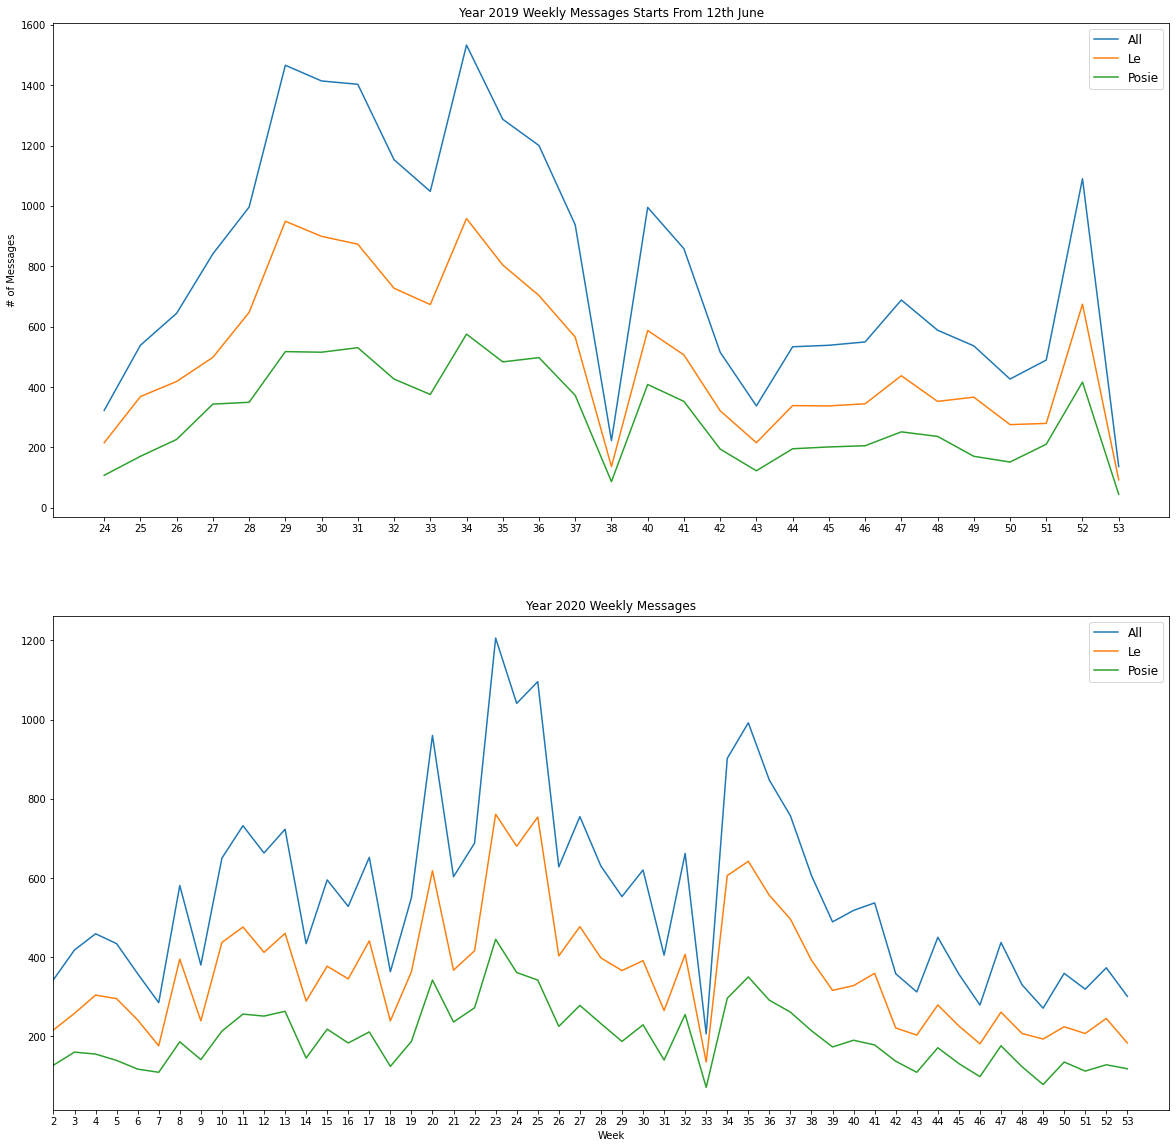

In [144]:
fig, ax = plt.subplots(2,figsize=(20,20))
ax[0].set_title('Year 2019 Weekly Messages Starts From 12th June')
draw_in_weeks(df19, ax = ax[0])
draw_in_weeks(ql19, ax = ax[0])
draw_in_weeks(zsy19, ax = ax[0])
ax[0].legend(['All','Le','Posie'], fontsize = 'large')

ax[0].set_ylabel('# of Messages')
ax[1].set_title('Year 2020 Weekly Messages')
ax[1].set_xlim(0,53)
draw_in_weeks(df20, ax = ax[1])
draw_in_weeks(ql20, ax = ax[1])
draw_in_weeks(zsy20, ax = ax[1])
ax[1].legend(['All','Le','Posie'], fontsize = 'large')
ax[1].set_xlabel('Week')
plt.subplots_adjust(hspace=0.2)

In [151]:
def draw_in_days(df, day = day_yr19):
    m = get_dict(df, day)
    m = mend_data(m, df)
    x,y = zip(*m.items())
#     print(x,y)
    plt.plot(x,y)
    plt.xticks(list(lrange(x[0],x[-1], 30)))

Text(0, 0.5, '# of Messages')

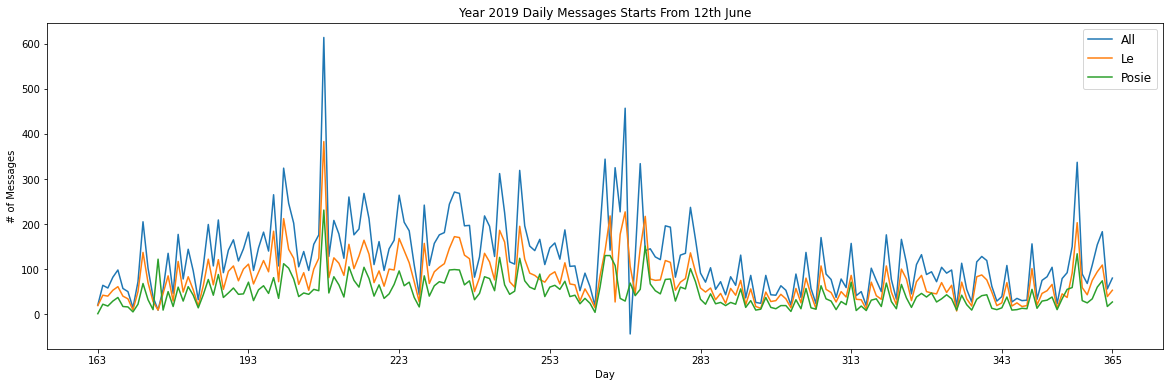

In [153]:
fig, ax = plt.subplots(figsize=(20,6))
draw_in_days(df19)
draw_in_days(ql19)
draw_in_days(zsy19)
ax.legend(['All','Le','Posie'], fontsize = 'large')
ax.set_title('Year 2019 Daily Messages Starts From 12th June')
ax.set_xlabel('Day')
ax.set_ylabel('# of Messages')

Text(0, 0.5, '# of Messages')

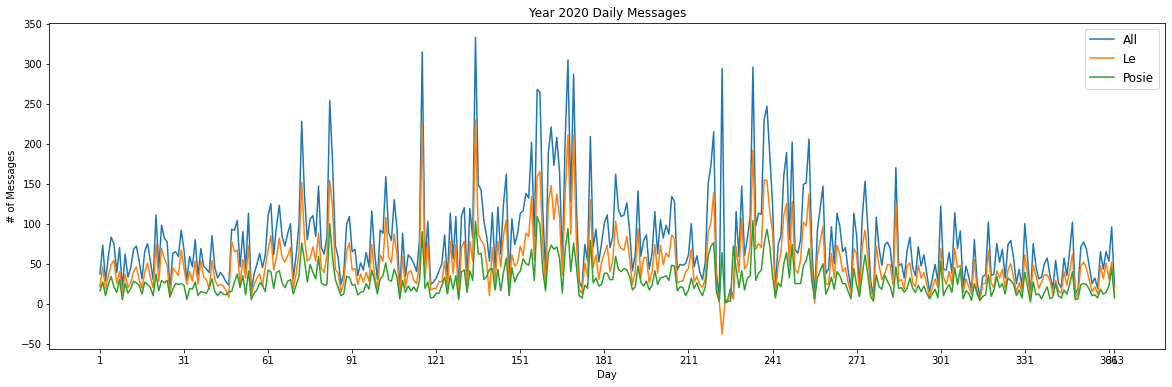

In [222]:
fig, ax = plt.subplots(figsize=(20,6))

days20 = draw_in_days(df20, day = day_yr20)
draw_in_days(ql20, day = day_yr20)
draw_in_days(zsy20, day = day_yr20)
ax.legend(['All','Le','Posie'], fontsize = 'large')

ax.set_title('Year 2020 Daily Messages')
ax.set_xlabel('Day')
ax.set_ylabel('# of Messages')

Text(0, 0.5, '# of Messages')

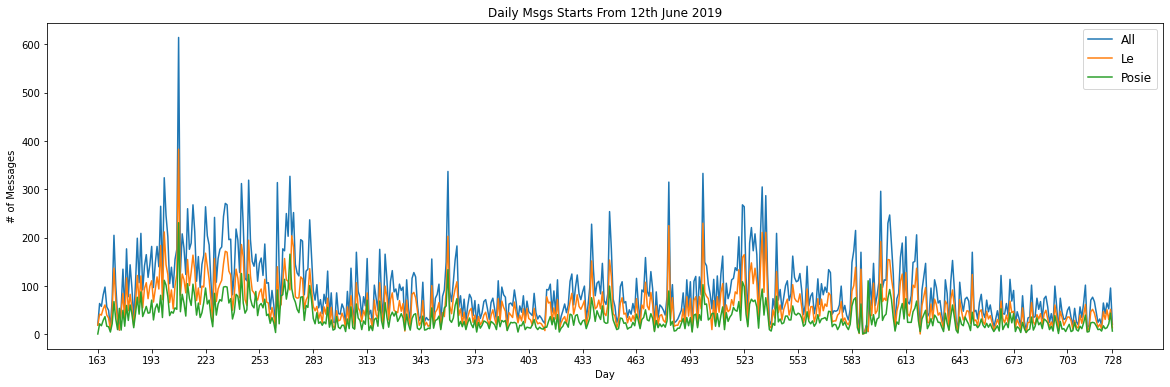

In [223]:
fig, ax = plt.subplots(figsize=(20,6))
draw_in_days(df)
draw_in_days(ql)
draw_in_days(zsy)
ax.legend(['All','Le','Posie'], fontsize = 'large')
ax.set_title('Daily Msgs Starts From 12th June 2019')
ax.set_xlabel('Day')
ax.set_ylabel('# of Messages')

In [156]:
# 24 Hours

def hour(x):
    return str(dt.datetime.fromtimestamp(x).hour)
#     return str(d.days + 1)

#Number of messages throughout a given year with units week
def draw_in_hours(df, day = day_yr19, ax = ax, plt = plt):
    df_copy = df.copy()
    df_copy.loc[:,'CreateTime'] = df_copy['CreateTime'].apply(hour)
#     print(df_copy['CreateTime'])
    d = [str(i) for i in sorted(list(set(df_copy['CreateTime'])))]
    m = {}
    for i in d:
        m[int(i)] = len(df_copy[df_copy['CreateTime'] == str(i)])
#     m.sort(key = lambda x:x.keys())
    m = dict(sorted(m.items()))
    x,y = zip(*m.items())
    ax.plot(x,y)
    
    idx = y.index(max(y))
    lx = x[y.index(max(y))]
    ly = y[idx]
    ax.annotate('{}'.format(ly), xy=(lx, ly), xytext=(lx-2, ly+20),
#             arrowprops=dict(facecolor='black', shrink=0.05),
            )
    ax.set_xlim(0,24,2)

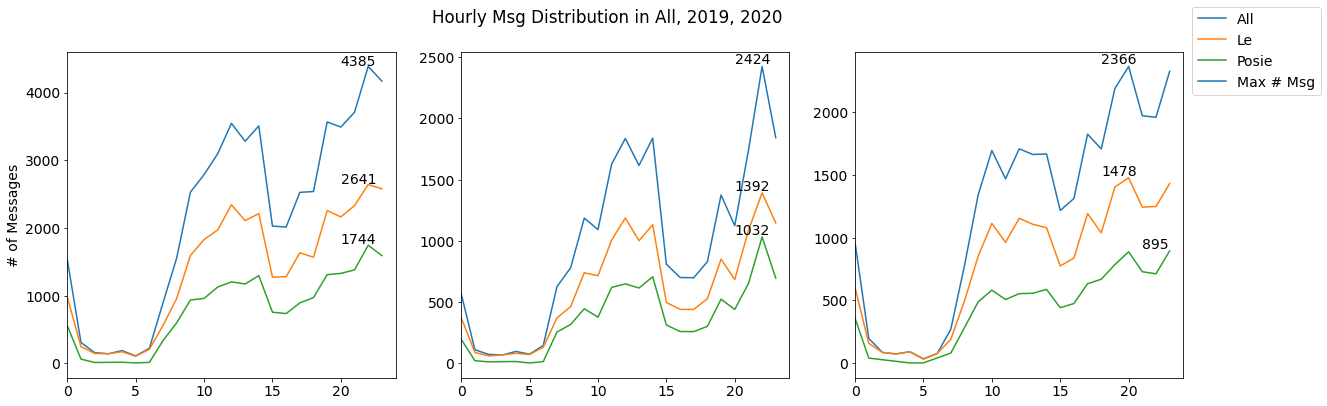

In [21]:
#Hours in total
fig, ax = plt.subplots(ncols = 3, figsize = (20,6))
d = draw_in_hours(df, ax = ax[0])
draw_in_hours(ql, ax = ax[0])
draw_in_hours(zsy, ax = ax[0])
draw_in_hours(df19, ax = ax[1])
draw_in_hours(ql19, ax = ax[1])
draw_in_hours(zsy19, ax = ax[1])
draw_in_hours(df20, ax = ax[2])
draw_in_hours(ql20, ax = ax[2])
draw_in_hours(zsy20, ax = ax[2])
fig.suptitle('Hourly Msg Distribution in All, 2019, 2020')
fig.legend(['All','Le','Posie','Max # Msg'], fontsize = 'medium', scatterpoints = 1)
# plt.legend(['All','Le','Posie'], fontsize = 'large')
fig.set_label('Week')
ax[0].set_ylabel('# of Messages')
fig.savefig('Hourly Msg Distribution in All, 2019, 2020')

In [186]:
#Word Group

def gen_wc(df = df, topK = 80, n = 0, ax = ax):
    msg = list(df[(df['Type'] == 1)]['Message'])
#     print(msg)
    tags = jieba.analyse.extract_tags(''.join(msg),topK=topK)
    text=' '.join(tags[3:])
    wc = WordCloud(background_color="white",
                   width=1500, height=1000,
                   min_font_size=40,
                   font_path="SimHei.ttf",
                  # max_font_size=300,  # 设置字体最大值
                   random_state=40,  # 设置有多少种随机生成状态，即有多少种配色方案
                   )  # 字体这里有个坑，一定要设这个参数。否则会显示一堆小方框wc.font_path="simhei.ttf"   # 黑体
    # wc.font_path="simhei.ttf"
    my_wordcloud = wc.generate(text)
    ax.imshow(my_wordcloud)
    ax.axis("off")

#     plt.show()
    return tags

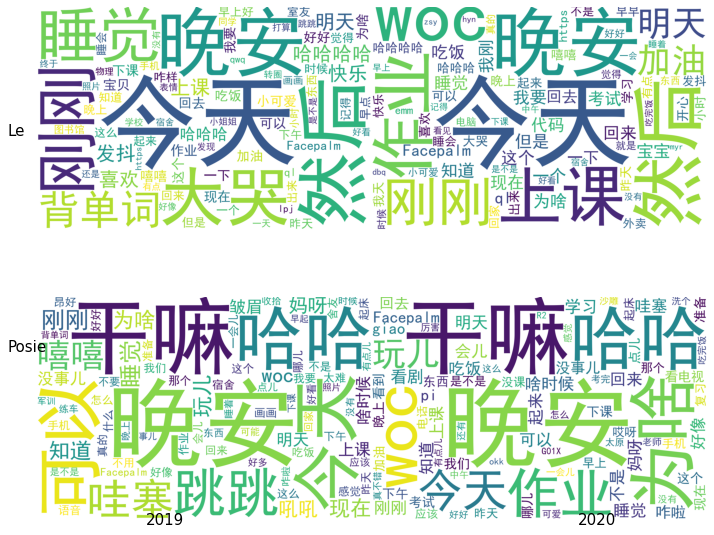

<Figure size 432x288 with 0 Axes>

In [218]:
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.set_label('2019')
ax2.set_label('2020')
ql19_tags = gen_wc(df = ql19, ax = ax1)
ql20_tags = gen_wc(df = ql20, ax = ax2)
zsy19_tags = gen_wc(df = zsy19, n=1, ax = ax3)
zsy20_tags = gen_wc(df = zsy20, n=1, ax = ax4)
plt.subplots_adjust(hspace=-0.2,wspace=0)
prop = {'size':15}
fig.text(0.25,0.2,'2019',prop)
fig.text(0.75,0.2,'2020',prop)
fig.text(0.09,0.4,'Posie',prop)
fig.text(0.09,0.65,'Le',prop)
plt.show()
plt.savefig('WordCloud', format = 'png')

In [219]:
plt.savefig?

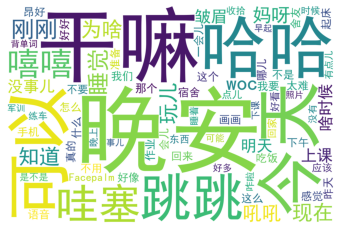

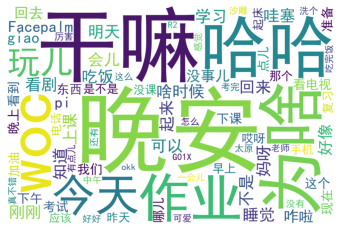

In [25]:
zsy19_tags = gen_wc(df = zsy19, n=1)
zsy20_tags = gen_wc(df = zsy20, n=1)

In [26]:
[i for i in x if not i in y or y.remove(i)]

NameError: name 'x' is not defined

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)

x=[1,2,3,4,5,6,7,8,9,10]
y=[1,1,1,2,10,2,1,1,1,1]
line, = ax.plot(x, y)

ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]

ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax.set_ylim(0,20)
plt.show()

In [109]:
dfs = [ql19,ql20,ql,zsy19,zsy20,zsy]
dfs_nm = ['ql19','ql20','ql','zsy19','zsy20','zsy']
def mean_msg(df):
    
    return int(len(df) / int(len(get_dict(df))) + 0.5)
mean_msg_list = [mean_msg(i) for i in dfs]

In [221]:
mean_msg(df19)

80

In [111]:
all_mean_msg = dict(zip(dfs_nm,mean_msg_list))
all_mean_msg

{'ql19': 75, 'ql20': 52, 'ql': 60, 'zsy19': 45, 'zsy20': 28, 'zsy': 34}

In [122]:
msg_df

,19,20,All
Le,75,52,60
Posie,45,28,34


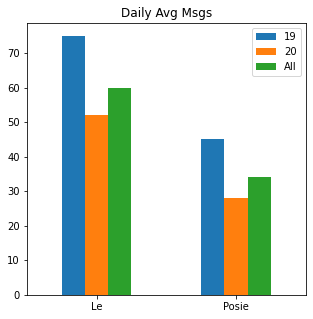

In [121]:
msg_df = pd.DataFrame(np.array(mean_msg_list).reshape(2,3), columns = ['19','20','All'], index = ['Le', 'Posie'])
msg_df.plot.bar(figsize=(5,5), rot = 0)
plt.title('Daily Avg Msgs')
plt.show()

In [31]:
ql20_mean_msg = len(ql20) / 365
ql19_mean_msg = len(ql19) / 365
ql_mean_msg = len(ql) / 365
zsy20_mean_msg = len(zsy20) / 365
zsy19_mean_msg = len(zsy19) / 365
zsy_mean_msg = len(zsy) / 365
print(ql20_mean_msg,ql19_mean_msg,ql_mean_msg,zsy19_mean_msg,zsy20_mean_msg,zsy_mean_msg)

51.3041095890411 39.87945205479452 91.18356164383562 23.90684931506849 28.134246575342466 52.04109589041096
